## This notebook computes $W_{\rm cmb}(\theta)$ and $F_l$

  - Uses input file `xl_ge_gg.txt`, which was created in `01_prepare_gal_filter.ipynb`
  - Uses input file `pixell_galmask.fits`, which was created in `02_prepare_mask.ipynb`
  - Output files `wcmb_90.fits` and `wcmb_150.fits` contain the CMB pixel weight function $W_{\rm cmb}(\theta)$ (in notation from the overleaf)
  - Output files `fl_90.fits` and `fl_150.fits` contain the CMB harmonic-space weight function $F_l$ (in notation from the overleaf)

In the overleaf, the CMB filter is specified by a pixel weight function $W_{\rm cmb}(\theta)$ and a harmonic-space filter $F_l$. In this notebook, we compute these objects and save them to disk, for use in later pipeline stages.

Following kSZquest (https://github.com/alexlague/kSZquest/blob/main/prepare_cmb.py), we define $W_{\rm cmb}(\theta)$ and $F_l$ as follows:

$$\begin{align} 
W_{\rm CMB}(\theta) &= \begin{cases}
1 & \mbox{ if noise $\le 70$ $\mu$K-arcmin, and allowed by galmask} \\
0 & \mbox{ otherwise}
\end{cases} \\[5pt]
F_l &= \frac{b_l}{C_l^{\rm tot}} \left( \frac{P_{ge}(k)}{P_{gg}(k)} \right)_{k=l/\chi_{\rm eff}}
\end{align}$$

Note that $W_{\rm cmb}(\theta)$ and $F_l$ are different at 90 vs 150 GHz.
To estimate $C_l^{\rm tot}$, we fit a model of the form:

$$C_l^{\rm tot} = C_l^{\rm CAMB} + \big( \mbox{power-law red noise} \big) + \big( \mbox{white noise} \big)$$

to the empirical $C_l$s of the ACT data. 
The details of the fitting procedure follow `utils.get_single_frequency_alms()` in kSZquest (re-packaged as `class kszx.CmbClFitter`):

   https://github.com/alexlague/kSZquest/blob/main/utils.py

## Imports and global variables

In [1]:
import kszx
import pixell
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# File 'global_params.py' in current directory
import global_params

lmin = global_params.ksz_lmin
lmax = global_params.ksz_lmax
act_dr = global_params.act_dr
act_rms_threshold = global_params.act_rms_threshold   # dict freq -> uK_arcmin

In [3]:
%%time
cosmo = kszx.Cosmology('planck18+bao', lmax=lmax+1000)

Running CAMB
CPU times: user 1min 42s, sys: 5.36 s, total: 1min 48s
Wall time: 2.76 s


## Read input files ($P_{ge}$, $P_{gg}$, galmask, cmb maps, ivar maps, beams)

In [4]:
xl = np.loadtxt('xl_ge_gg.txt')
assert xl.shape == (lmax+1,3)
assert np.all(xl[:,0] == np.arange(lmax+1))
xl_ge = xl[:,1]
xl_gg = xl[:,2]

In [5]:
galmask = kszx.pixell_utils.read_map('pixell_galmask.fits')

Reading pixell_galmask.fits


In [6]:
cmb_maps = { f: kszx.act.read_cmb(freq=f, dr=act_dr, download=True) for f in [90,150] }
ivar_maps = { f: kszx.act.read_ivar(freq=f, dr=act_dr, download=True) for f in [90,150] }
beams = { f: kszx.act.read_beam(freq=f, dr=act_dr, download=True) for f in [90,150] }

kszx: environment variable $KSZX_DATA_DIR not defined, using /home/kmsmith/kszx_data instead
Reading /home/kmsmith/kszx_data/act/dr5.01/act_planck_dr5.01_s08s18_AA_f090_daynight_map_srcfree.fits
Reading /home/kmsmith/kszx_data/act/dr5.01/act_planck_dr5.01_s08s18_AA_f150_daynight_map_srcfree.fits
Reading /home/kmsmith/kszx_data/act/dr5.01/act_planck_dr5.01_s08s18_AA_f090_daynight_ivar.fits
Reading /home/kmsmith/kszx_data/act/dr5.01/act_planck_dr5.01_s08s18_AA_f150_daynight_ivar.fits
Reading /home/kmsmith/kszx_data/act/dr5.01/beams/act_planck_dr5.01_s08s18_f090_daynight_beam.txt
Reading /home/kmsmith/kszx_data/act/dr5.01/beams/act_planck_dr5.01_s08s18_f150_daynight_beam.txt


## Main function process_freq(), called separately for 90 and 150 GHz

In [7]:
def process_freq(freq):
    rms_threshold = act_rms_threshold[freq]  # uK-arcmin
    print(f'{freq=} {rms_threshold=}')
    
    cmb = cmb_maps[freq]
    ivar = ivar_maps[freq]
    bl = beams[freq]

    # CMB weight function W_CMB(theta)
    # Logic here follows kSZquest/prepare_cmb.py
    # kszx.pixell_utils.uK_arcmin_from_ivar() is the same as orphics.maps.rms_rom_ivar().
    wcmb = galmask.copy()
    wcmb *= (kszx.pixell_utils.uK_arcmin_from_ivar(ivar) < rms_threshold)

    print('\n*************** CMB with mask applied ***************\n')
    
    kszx.pixell_utils.plot_map(cmb*wcmb, downgrade=20)

    # I experimented with a lot of CmbClFitter flags that turned out not to make much difference!
    # The default CmbClFitter returns a slightly different (but qualitatively similar) fit to Alex + Mat.
    # If you want to recover Alex + Mat's fit, you should use these CmbClFitter constructor args:
    #
    #  lmin = 1000
    #  lmax = 8000
    #  fit_cmb_amplitude = True
    #  fit_alpha = False
    #  fit_lred = False
    #  beamed_red_noise = False
    #  uniform_lweight = True
    #
    # For more info, see the CmbClFitter class docstring:
    # https://kszx.readthedocs.io/en/latest/cmb_cl_fitter.html
    
    cl_fitter = kszx.CmbClFitter(
        cosmo = cosmo, 
        cmb_map = cmb, 
        weight_map = wcmb,
        bl = bl,
        lmin = lmin, 
        lmax = lmax,
        ivar = ivar 
    )

    cl_fitter.make_plots()

    # Note that cl_fitter.cl_tot is beam-convolved.
    fl = bl[:lmax+1] * xl_ge / xl_gg / cl_fitter.cl_tot
    fl[:lmin] = 0

    plt.plot(np.arange(lmin,lmax+1), fl[lmin:])
    plt.xlabel('$l$')
    plt.ylabel(r'$F_l$')
    plt.title(r'CMB filter $F_l$')
    plt.show()

    print('*************** Writing files ***************')
    
    kszx.pixell_utils.write_map(f'wcmb_{freq}.fits', wcmb)
    
    fl_filename = f'fl_{freq}.txt'
    print(f'Writing {fl_filename}')
    
    np.savetxt(
        fl_filename,
        np.transpose([np.arange(lmax+1), fl, cl_fitter.cl_tot]),
        header = ('Col 0: l\n' +
                  'Col 1: F_l (CMB l-weighting in kSZ quadratic estimator)\n' +
                  'Col 2: C_l (Fit for CMB power spectrum, beam-convolved, includes noise)\n')
    )
        

## 90 GHz starts here

freq=90 rms_threshold=70.0

*************** CMB with mask applied ***************



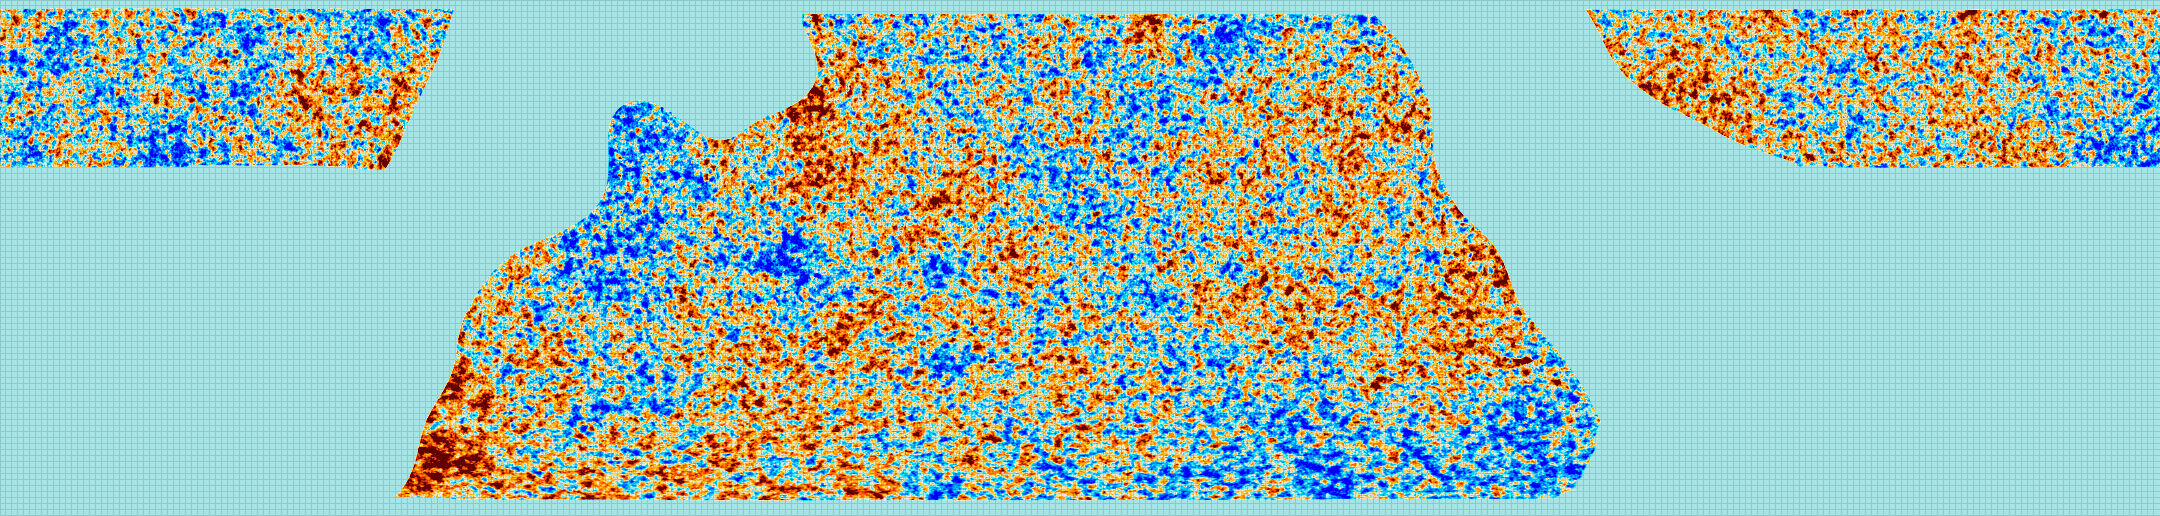

CmbClFitter: equivalent noise level of ivar map = 30.125246584588993 uK-arcmin
CmbClFitter._do_fit()
    alpha = -3.014334745888598
    lred = 1499.9217422066804
    cmb_ampl = 1.0
    white_ampl = 4.682266905085862e-05  (uK_arcmin = 23.523501419320326)
    red_ampl = 0.0004143776828340187    (l_knee = 3091.9817605461826)


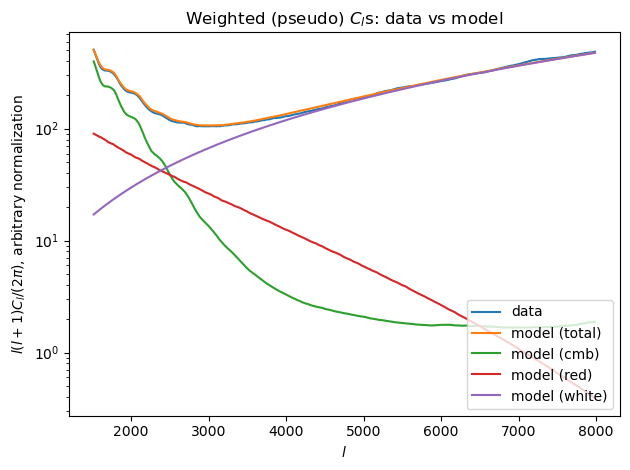

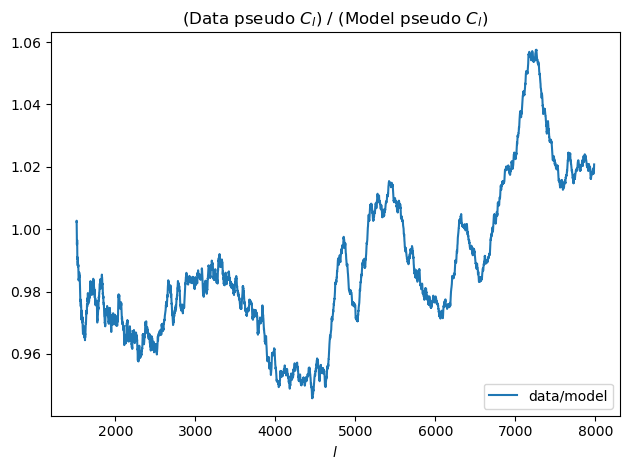

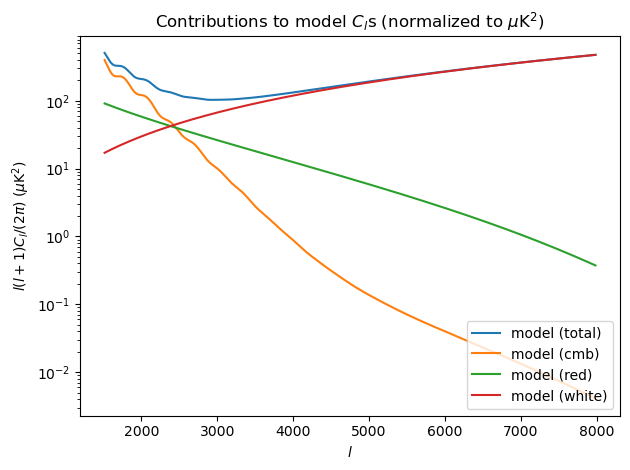

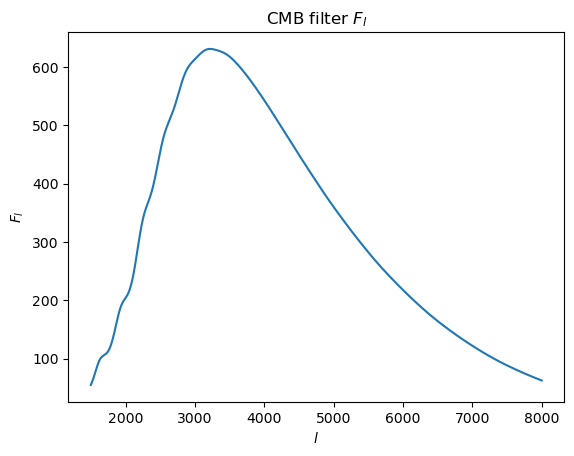

*************** Writing files ***************
Writing wcmb_90.fits
Writing fl_90.txt


In [8]:
process_freq(90)

## 150 GHz starts here

freq=150 rms_threshold=70.0

*************** CMB with mask applied ***************



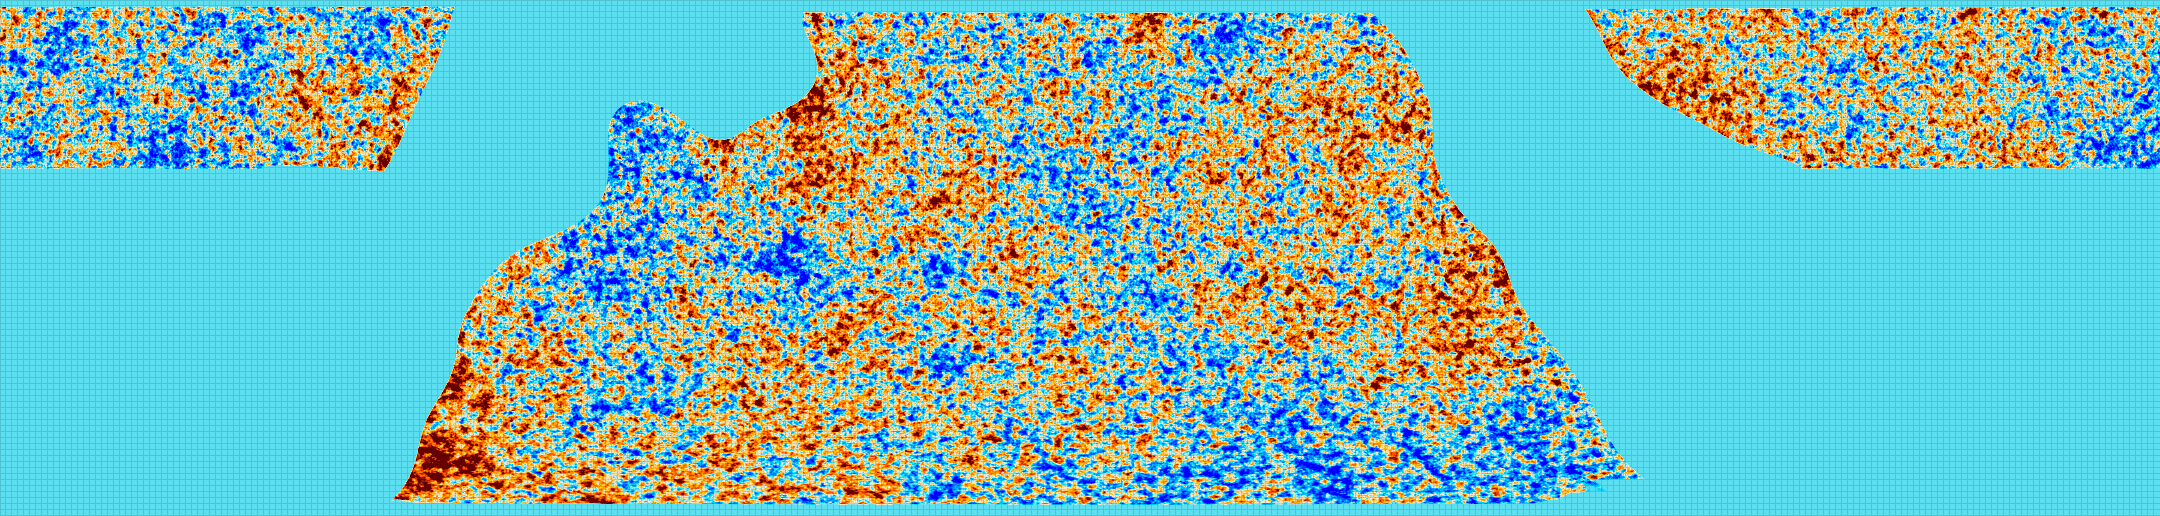

CmbClFitter: equivalent noise level of ivar map = 24.174448851877 uK-arcmin
CmbClFitter._do_fit()
    alpha = -3.8443028700243773
    lred = 2048.296227512969
    cmb_ampl = 1.0
    white_ampl = 5.151694528315952e-05  (uK_arcmin = 24.674532587093704)
    red_ampl = 0.0003140937850492004    (l_knee = 2400.589743451491)


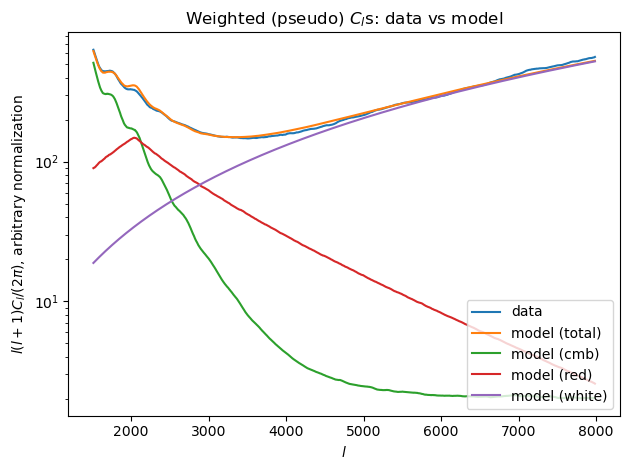

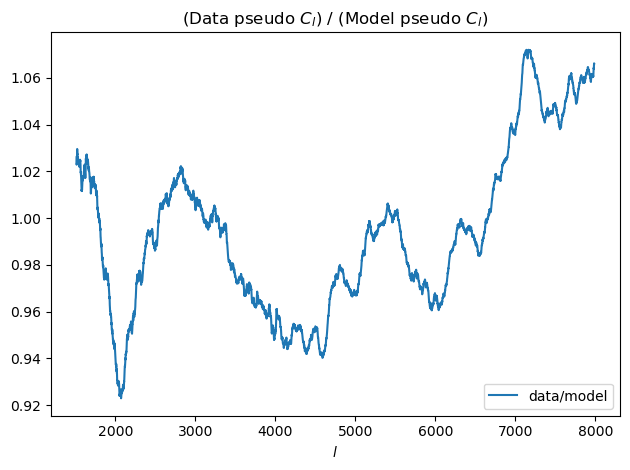

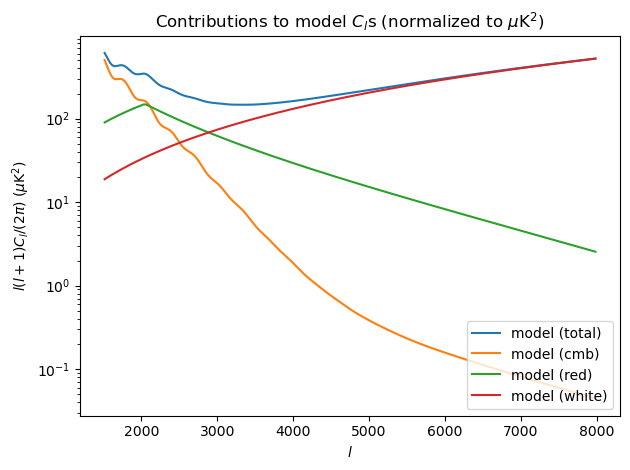

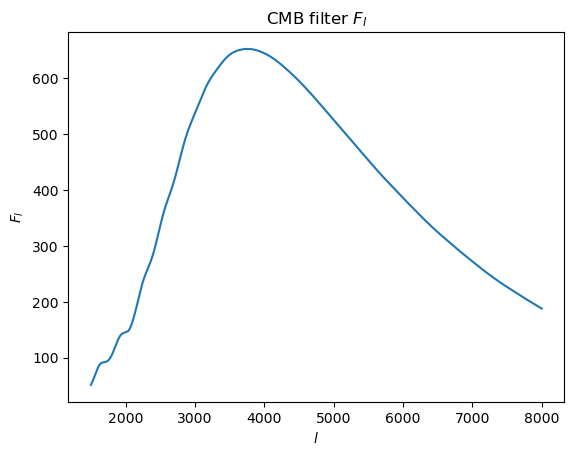

*************** Writing files ***************
Writing wcmb_150.fits
Writing fl_150.txt


In [9]:
process_freq(150)

## Just curious: how correlated are 90 and 150 GHz?

In [10]:
# First let's define a CMB mask / weight function
# We use the same weight function for 90 and 150 GHz.

wcmb = galmask.copy()
wcmb *= (kszx.pixell_utils.uK_arcmin_from_ivar(ivar_maps[90]) < act_rms_threshold[90])
wcmb *= (kszx.pixell_utils.uK_arcmin_from_ivar(ivar_maps[150]) < act_rms_threshold[150])

In [11]:
alm90 = kszx.pixell_utils.map2alm(wcmb * cmb_maps[90], lmax)
alm150 = kszx.pixell_utils.map2alm(wcmb * cmb_maps[150], lmax)

In [12]:
cl_90_90 = pixell.curvedsky.alm2cl(alm90, alm90)
cl_90_150 = pixell.curvedsky.alm2cl(alm90, alm150)
cl_150_150 = pixell.curvedsky.alm2cl(alm150, alm150)

In [13]:
s = 100   # smoothing scale Delta(l), to make the correlation coefficient plot less noisy.
ell = kszx.utils.boxcar_sum(np.arange(lmax+1), s, normalize=True)
r = kszx.utils.boxcar_sum(cl_90_150 / np.sqrt(cl_90_90 * cl_150_150), s, normalize=True)

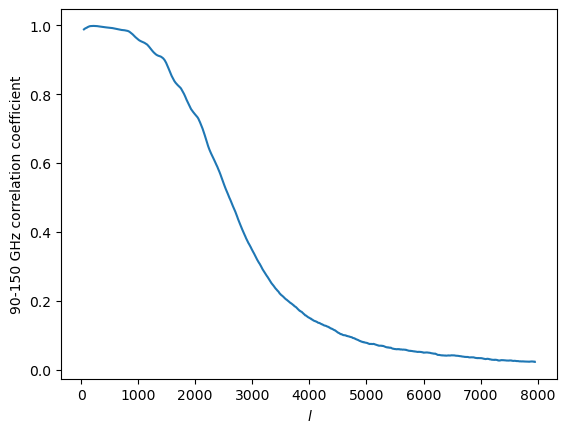

In [14]:
plt.plot(ell, r)
plt.xlabel(r'$l$')
plt.ylabel('90-150 GHz correlation coefficient')
plt.show()